# Getting Fairness Correction Metrics

#### Dictionaries for file name, protected attribute and label for every dataset

In [1]:
Income = {
    'df': 'income_onehot.csv',
    'pa': 'sex',
    'label': 'label',
}

COMPAS = {
    'df': 'compas_onehot.csv',
    'pa': 'race',
    'label': 'label',
}

German = {
    'df': 'german_onehot.csv',
    'pa': 'gender',
    'label': 'label',
}

DSets = {
    'Income': Income,
    'COMPAS': COMPAS,
    'German': German,
}

#### Load data and assign df, pa and label variables based on dataset

In [5]:
import pandas as pd
import numpy as np

# Set desired Dataset here, values can be: 'Income', 'COMPAS', 'German'
dset = 'Income'

url = 'https://raw.githubusercontent.com/vladoxNCL/fairCorrect/master/Datasets/'
df = pd.read_csv(url + DSets[dset]['df'], header=0)
pa = DSets[dset]['pa']
label = DSets[dset]['label']

#### Split data into train/test sets

In [112]:
def ttSplit(df, ts=0.10):
    """Train / Test split dataframe df with test proportion ts. Also get
    an additional train /test set with protected attribute reversed for counterfactual analysis."""
    
    from sklearn.model_selection import train_test_split

    train, test = train_test_split(df, test_size=ts)

    X_test = test.drop([label], axis=1).values
    y_test = test[label].values

    rtest = test.copy()
    ftest = test.copy()
    utest = test.copy()
    
    rtest[pa] = [0 if s == 1 else 1 for s in test[pa]]
    ftest[pa] = 1
    utest[pa] = 0
    
    rX_test = rtest.drop([label], axis=1).values
    ry_test = rtest[label].values
    fX_test = ftest.drop([label], axis=1).values
    fy_test = ftest[label].values
    uX_test = utest.drop([label], axis=1).values
    uy_test = utest[label].values
    
    ttdict = {
        'train': train,
        'test': test,
        'rtest': rtest,
        'ftest': ftest,
        'utest': utest,
        'X_test': X_test,
        'y_test': y_test,
        'rX_test': rX_test,
        'ry_test': ry_test,
        'fX_test': fX_test,
        'fy_test': fy_test,
        'uX_test': uX_test,
        'uy_test': uy_test,
    }

    return ttdict

#### Find favoured group

In [113]:
def findFav(ttdict, pa=pa, label=label):
    train = ttdict['train']

    pos_rates = [train[(train[pa] == u) & (train[label] == 1)].shape[0] / train[train[pa] == u].shape[0]
                 for u in train[pa].unique()]
    max_value = max(pos_rates)
    max_index = pos_rates.index(max_value)

    # Favoured group
    fav = train[pa].unique()[max_index]
    return fav

## Fairness Correction Functions

In [114]:
def fairCorrectUnder(df, pa, fav, d=1):
    """Correct the proportion of positive cases for favoured and unfavoured subgroups through
    subsampling the favoured positive and unfavoured negative classes. Parameter d should be
    a number between -1 and 1 for this to work properly."""
    
    # import math for floor function
    import math
    
    # subset favoured positive, favoured negative, unfavoured positive, unfavoured negative
    fav_pos = df[(df[pa] == fav) & (df.label == 1)]
    fav_neg = df[(df[pa] == fav) & (df.label == 0)]
    unfav_pos = df[(df[pa] != fav) & (df.label == 1)]
    unfav_neg = df[(df[pa] != fav) & (df.label == 0)]
    
    # get favoured and unfavoured number of rows
    fav_size = fav_pos.shape[0] + fav_neg.shape[0]
    unfav_size = unfav_pos.shape[0] + unfav_neg.shape[0]

    # get positive ratios for favoured and unfavoured
    fav_pr = fav_pos.shape[0] / fav_size
    unfav_pr = unfav_pos.shape[0] / unfav_size
    pr = df[df[label] == 1].shape[0] / df.shape[0]

    # coefficients for fitting quad function
    a = ((fav_pr + unfav_pr) / 2) - pr
    b = (fav_pr - unfav_pr) / 2
    c = pr

    # corrected ratios
    corr_fpr = (a * (d ** 2)) + (b * d) + c
    corr_upr = (a * (d ** 2)) - (b * d) + c
    
    # correcting constants
    fav_k = corr_fpr / (1 - corr_fpr)
    unfav_k = (1 - corr_upr) / corr_upr
    
    # sample sizes for fav_pos and unfav_neg
    fav_pos_size = math.floor(fav_neg.shape[0] * fav_k)
    unfav_neg_size = math.floor(unfav_pos.shape[0] * unfav_k)
    
    # samples from fav_pos and unfav_neg to correct proportions
    corr_fav_pos = fav_pos.sample(fav_pos_size)
    corr_unfav_neg = unfav_neg.sample(unfav_neg_size)
    
    # concatenate df's
    corr_dfs = [corr_fav_pos, fav_neg, unfav_pos, corr_unfav_neg]
    corr_df = pd.concat(corr_dfs)
    
    return corr_df

In [115]:
def fairCorrectOver(df, pa, fav, d=1):
    """Correct the proportion of positive cases for favoured and unfavoured subgroups through
    oversampling the unfavoured positive and favoured negative classes. Parameter d should be
    a number between -1 and 1 for this to work properly."""
    
    # import math for floor function
    import math
    
    # subset favoured positive, favoured negative, unfavoured positive, unfavoured negative
    fav_pos = df[(df[pa] == fav) & (df.label == 1)]
    fav_neg = df[(df[pa] == fav) & (df.label == 0)]
    unfav_pos = df[(df[pa] != fav) & (df.label == 1)]
    unfav_neg = df[(df[pa] != fav) & (df.label == 0)]
    
    # get favoured and unfavoured number of rows
    fav_size = fav_pos.shape[0] + fav_neg.shape[0]
    unfav_size = unfav_pos.shape[0] + unfav_neg.shape[0]

    # get positive ratios for favoured and unfavoured
    fav_pr = fav_pos.shape[0] / fav_size
    unfav_pr = unfav_pos.shape[0] / unfav_size
    pr = df[df[label] == 1].shape[0] / df.shape[0]

    # coefficients for fitting quad function
    a = ((fav_pr + unfav_pr) / 2) - pr
    b = (fav_pr - unfav_pr) / 2
    c = pr

    # corrected ratios
    corr_fpr = (a * (d ** 2)) + (b * d) + c
    corr_upr = (a * (d ** 2)) - (b * d) + c
    
    # correcting constants
    fav_k = (1 - corr_fpr) / corr_fpr
    unfav_k = corr_upr / (1 - corr_upr)
       
    # sample sizes for unfav_pos and fav_neg
    unfav_pos_size = math.floor(unfav_neg.shape[0] * unfav_k)
    fav_neg_size = math.floor(fav_pos.shape[0] * fav_k)
    
    # samples from fav_pos and unfav_neg to correct proportions
    corr_unfav_pos = unfav_pos.sample(unfav_pos_size, replace=True)
    corr_fav_neg = fav_neg.sample(fav_neg_size, replace=True)
    
    # concatenate df's
    corr_dfs = [corr_unfav_pos, fav_pos, unfav_neg, corr_fav_neg]
    corr_df = pd.concat(corr_dfs)
    
    return corr_df

In [116]:
def fairCorrectSMOTE(df, pa, fav, d=1):
    """Correct the proportion of positive cases for favoured and unfavoured subgroups through 
    oversampling the unfavoured positive and favoured negative classes. Parameter d should be
    a number between -1 and 1 for this to work properly."""
    
    # import math for floor function, SMOTE for oversampling
    import math
    from imblearn.over_sampling import SMOTE
    
    # Put label last for easier manipulation
    df = df[[c for c in df if c not in ['label']] + ['label']]
    
    # subset favoured positive, favoured negative, unfavoured positive, unfavoured negative
    fav_pos = df[(df[pa] == fav) & (df.label == 1)]
    fav_neg = df[(df[pa] == fav) & (df.label == 0)]
    unfav_pos = df[(df[pa] != fav) & (df.label == 1)]
    unfav_neg = df[(df[pa] != fav) & (df.label == 0)]
    
    # get favoured and unfavoured number of rows
    fav_size = fav_pos.shape[0] + fav_neg.shape[0]
    unfav_size = unfav_pos.shape[0] + unfav_neg.shape[0]

    # get positive ratios for favoured and unfavoured
    fav_pr = fav_pos.shape[0] / fav_size
    unfav_pr = unfav_pos.shape[0] / unfav_size
    pr = df[df[label] == 1].shape[0] / df.shape[0]

    # coefficients for fitting quad function
    a = ((fav_pr + unfav_pr) / 2) - pr
    b = (fav_pr - unfav_pr) / 2
    c = pr

    # corrected ratios
    corr_fpr = (a * (d ** 2)) + (b * d) + c
    corr_upr = (a * (d ** 2)) - (b * d) + c
    
    # correcting constants
    fav_k = (1 - corr_fpr) / corr_fpr
    unfav_k = corr_upr / (1 - corr_upr)
    
    # SMOTE oversample UP & FN to correct constant
    
    sm = SMOTE()
    auxfav = fav_pos.sample(math.floor(fav_pos.shape[0] * fav_k),
                               replace=True)
    auxunfav = unfav_neg.sample(math.floor(unfav_neg.shape[0] * unfav_k),
                                   replace=True)
    
    dff_pre = pd.concat([auxfav, fav_neg])
    dfu_pre = pd.concat([unfav_pos, auxunfav])
    
    # Split in X & y for SMOTE to work
    Xf_pre = dff_pre.drop(['label'], axis=1).values
    Xu_pre = dfu_pre.drop(['label'], axis=1).values
    yf_pre = dff_pre.label.values
    yu_pre = dfu_pre.label.values

    # Apply SMOTE
    X_smf, y_smf = sm.fit_sample(Xf_pre, yf_pre)
    X_smu, y_smu = sm.fit_sample(Xu_pre, yu_pre)
    
    # Put back together into dataframes
    y_smf = y_smf.reshape((y_smf.shape[0], 1))
    X_smf = np.append(X_smf, y_smf, axis=1)
    y_smu = y_smu.reshape((y_smu.shape[0], 1))
    X_smu = np.append(X_smu, y_smu, axis=1)
    smfDF = pd.DataFrame(X_smf, columns=df.columns.tolist())
    smuDF = pd.DataFrame(X_smu, columns=df.columns.tolist())
    
    # concatenate df's
    corr_dfs = [smfDF[smfDF.label == 0], smuDF[smuDF.label == 1], fav_pos, unfav_neg]
    corr_df = pd.concat(corr_dfs)
    
    return corr_df

In [118]:
def fairCorrectPSP(df, pa, fav, d=1):
    from sklearn.naive_bayes import GaussianNB as nb
    import math
    
    df2 = df.copy()
    
    # Train NB model and get prediction confidence
    Xnb = df.drop([label], axis=1).values
    ynb = df[label].values
    
    model = nb()
    model.fit(Xnb, ynb)
    logProbs = model.predict_log_proba(Xnb)
    df2['pPos'] = [logProbs[i][1] for i in range(len(logProbs))]
    
    # subset favoured positive, favoured negative, unfavoured positive, unfavoured negative
    fav_pos = (df2[(df2[pa] == fav) & (df2[label] == 1)]
               .sort_values('pPos', ascending=True))
    fav_neg = (df2[(df2[pa] == fav) & (df2[label] == 0)]
               .sort_values('pPos', ascending=False))
    unfav_pos = (df2[(df2[pa] != fav) & (df2[label] == 1)]
                 .sort_values('pPos', ascending=True))
    unfav_neg = (df2[(df2[pa] != fav) & (df2[label] == 0)]
                 .sort_values('pPos', ascending=False))
    
    # drop aux columns
    fav_pos = fav_pos.drop(['pPos'], axis=1)
    fav_neg = fav_neg.drop(['pPos'], axis=1)
    unfav_pos = unfav_pos.drop(['pPos'], axis=1)
    unfav_neg = unfav_neg.drop(['pPos'], axis=1)
    
    if d < 1:

        # get favoured and unfavoured number of rows
        fav_size = fav_pos.shape[0] + fav_neg.shape[0]
        unfav_size = unfav_pos.shape[0] + unfav_neg.shape[0]

        # get positive ratios for favoured and unfavoured
        fav_pr = fav_pos.shape[0] / fav_size
        unfav_pr = unfav_pos.shape[0] / unfav_size
        pr = df[df[label] == 1].shape[0] / df.shape[0]

        # coefficients for fitting quad function
        a = ((fav_pr + unfav_pr) / 2) - pr
        b = (fav_pr - unfav_pr) / 2
        c = pr

        # corrected ratios
        corr_fpr = (a * (d ** 2)) + (b * d) + c
        corr_upr = (a * (d ** 2)) - (b * d) + c

        # number of elements to remove or add
        fav_move = math.floor((fav_pr - corr_fpr) * fav_size)
        unfav_move = math.floor((corr_upr - unfav_pr) * unfav_size)

        # elements to add
        ext_fn = pd.concat([fav_neg] * math.ceil(fav_move / fav_neg.shape[0]), ignore_index=True)
        ext_up = pd.concat([unfav_pos] * math.ceil(unfav_move / unfav_pos.shape[0]), ignore_index=True)
    
        # remove from fp and un
        fav_pos = fav_pos.tail(fav_pos.shape[0] - fav_move)
        unfav_neg = unfav_neg.tail(unfav_neg.shape[0] - unfav_move)
    
        # add to fn and up
        fav_neg = pd.concat([fav_neg, ext_fn.head(fav_move)], ignore_index=True) 
        unfav_pos = pd.concat([unfav_pos, ext_up.head(unfav_move)], ignore_index=True)
    
    # concatenate df's
    corr_dfs = [fav_pos, fav_neg, unfav_pos, unfav_neg]
    corr_df = pd.concat(corr_dfs)
    
    return corr_df

### Make array of corrected training sets for different values of *d*

In [119]:
def correctTrains(train, pa, fav, FCfun):
    corr_trains = []
    Xs = []
    ys = []

    for i in range(11):
        tdf = FCfun(train, pa, fav, d=1-(0.2*i))
        corr_trains.append(tdf)
    
    for i in range(11):
        X = corr_trains[i].drop([label], axis=1).values
        y = corr_trains[i][label].values
        Xs.append(X)
        ys.append(y)
    
    corrected = {
        'corr_trains': corr_trains,
        'Xs': Xs,
        'ys': ys,
    }
    
    return corrected

### Get predictions for test set out of models learned from the different training sets

In [120]:
def makePreds(Xs, ys, X_test):
    from sklearn.linear_model import LogisticRegression

    models = []
    preds = []

    for i in range(11):
        model = LogisticRegression()
        model.fit(Xs[i], ys[i])
        models.append(model)
    
        p = model.predict(X_test)
        preds.append(p)
    
    outputs = {
        'models': models,
        'preds': preds,
    }
    
    return outputs

#### Get different models' coefficients

In [121]:
def getCoefs(train, models):
    train2 = train.drop([label], axis=1)

    dfc = pd.DataFrame(columns=train2.columns.values)
    for i in range(dfc.shape[1]):
        dfc[dfc.columns.values[i]] = [models[j].coef_[0][i] for j in range(11)]
    dfc['disparity'] = [(1 - 0.2*i) for i in range(11)]
    return dfc

#### Add predictions to test sets for analysis

In [122]:
def addPreds(test, preds):
    for i in range(11):
        test['pred' + str(i)] = preds[i]
    return test

### Main function, performs the whole process

In [123]:
def Workflow(df, n, pa, label, FCfun):
    Coefs = []
    Tests = []
    rTests = []
    fTests = []
    uTests = []

    for i in range(n):
        ttdict = ttSplit(df, 0.10)
        train = ttdict['train']
        test = ttdict['test']
        rtest = ttdict['rtest']
        ftest = ttdict['ftest']
        utest = ttdict['utest']
        X_test = ttdict['X_test']
        rX_test = ttdict['rX_test']
        fX_test = ttdict['fX_test']
        uX_test = ttdict['uX_test']
        fav = findFav(ttdict, pa, label)
        
        corrected = correctTrains(train, pa, fav, FCfun)
        Xs = corrected['Xs']
        ys = corrected['ys']
        
        outputs = makePreds(Xs, ys, X_test)
        models = outputs['models']
        preds = outputs['preds']
        
        rOutputs = makePreds(Xs, ys, rX_test)
        rpreds = rOutputs['preds']
        
        fOutputs = makePreds(Xs, ys, fX_test)
        fpreds = fOutputs['preds']
        
        uOutputs = makePreds(Xs, ys, uX_test)
        upreds = uOutputs['preds']
        
        coefs = getCoefs(train, models)
        test = addPreds(test, preds)
        rtest = addPreds(rtest, rpreds)
        ftest = addPreds(ftest, fpreds)
        utest = addPreds(utest, upreds)
        
        Coefs.append(coefs)
        Tests.append(test)
        rTests.append(rtest)
        fTests.append(ftest)
        uTests.append(utest)
        
    Outs = {
        'Coefs': Coefs,
        'Tests': Tests,
        'rTests': rTests,
        'fTests': fTests,
        'uTests': uTests,
        'fav': fav,
        'fun': FCfun.__name__,
    }
    
    return Outs

### Get metrics for all five correction methods

In [124]:
expNames = [
    'expUnder',
    'expOver',
    'expSMOTE',
    'expPSP',
]

fcFunctions = [
    fairCorrectUnder,
    fairCorrectOver,
    fairCorrectSMOTE,
    fairCorrectPSP,
]

combined = zip(expNames, fcFunctions)

experiments = {name: Workflow(df, 50, pa, label, func) for name, func in combined}

/home/vladox/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/vladox/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/vladox/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

/home/vladox/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/vladox/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/vladox/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

/home/vladox/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/vladox/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/vladox/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

#### Get Volatility Function

In [125]:
def getVolas(df):
    cols = {
        'real': df[label],
        'base': df['pred0'],
    }

    for i in range(10):
        cols['pred' + str(i + 1)] = df['pred' + str(i + 1)]

    vDF = pd.DataFrame(cols)
    
    for i in range(10):
        vDF['vola' + str(i + 1)] = [0 if (p == q and p == r) else
                                    1 if (p == r or  q == r) else
                                    2 if (p == q and p != r) else
                                    3 for (p, q, r) in zip(vDF.base,
                                                           vDF['pred' + str(i + 1)],
                                                           vDF.real)]
    vDF = vDF.drop(['real', 'base'], axis=1)

    for i in range(1, 11):
        vDF = vDF.drop(['pred' + str(i)], axis=1)
        
    test2 = df.reset_index()
    vdf2 = vDF.reset_index()
    testdf = pd.concat([test2,vdf2], axis=1)
    testdf = testdf.drop(['index'], axis=1)

    vola = [[np.nan], [np.nan], [np.nan]]
    uvola = [[np.nan], [np.nan], [np.nan]]
    fvola = [[np.nan], [np.nan], [np.nan]]

    for i in range(10):
        for j in range(3):
        
            if j in testdf['vola' + str(i + 1)].unique():
                vcn = testdf['vola' + str(i + 1)].value_counts(normalize=True, sort=False)[j]
            else:
                vcn = 0
            vola[j].append(vcn)
        
            if j in testdf[testdf[pa] != fav]['vola' + str(i + 1)].unique():
                uvcn = testdf[testdf[pa] != fav]['vola' + str(i + 1)].value_counts(normalize=True, sort=False)[j]
            else:
                uvcn = 0
            uvola[j].append(uvcn)
        
            if j in testdf[testdf[pa] == fav]['vola' + str(i + 1)].unique():
                fvcn = testdf[testdf[pa] == fav]['vola' + str(i + 1)].value_counts(normalize=True, sort=False)[j]
            else:
                fvcn = 0
            fvola[j].append(fvcn)
    
    Volas = {
        'vola': vola,
        'uvola': uvola,
        'fvola': fvola,
    }
    
    return Volas

#### Produce the metrics and coefficients dataframes

In [126]:
def getMetrics(exp):    
    from sklearn.metrics import accuracy_score
    
    Coefs = exp['Coefs']
    Tests = exp['Tests']
    rTests = exp['rTests']
    fTests = exp['fTests']
    uTests = exp['uTests']
    fav = exp['fav']
    sampstrat = exp['fun']
    Metrics = []

    for i in range(len(Tests)):
        test = Tests[i]
        rtest = rTests[i]
        ftest = fTests[i]
        utest = uTests[i]
        dvals = [round((1 - 0.2 * i), 1) for i in range(11)]
        accs = [accuracy_score(test.label, test['pred' + str(i)]) for i in range(11)]
        f_accs = [accuracy_score(test[test[pa] == 0].label, test[test[pa] == 0]['pred' + str(i)]) for i in range(11)]
        m_accs = [accuracy_score(test[test[pa] == 1].label, test[test[pa] == 1]['pred' + str(i)]) for i in range(11)]
        unfav_pos = [test[test[pa] != fav]['pred' + str(i)].value_counts(normalize=True)[1]
                     for i in range(11)]
        fav_pos = [test[test[pa] == fav]['pred' + str(i)].value_counts(normalize=True)[1]
                   for i in range(11)]
        tot_pos = [test['pred' + str(i)].value_counts(normalize=True)[1]
                   for i in range(11)]

        metrics = pd.DataFrame({
            'disparity': dvals,
            'accuracy': accs,
            'fem_accu': f_accs,
            'male_accu': m_accs,
            'positive_rate': tot_pos,
            'unfav_positive_rate': unfav_pos,
            'fav_positive_rate': fav_pos,
        })

        # Equality of Opportunity Metrics
        metrics['uo'] = [len(test[(test[pa] != fav) & (test.label == 1) & (test['pred' + str(i)] == 1)]) /
                         len(test[(test[pa] != fav) & (test.label == 1)]) for i in range(11)]
        metrics['fo'] = [len(test[(test[pa] == fav) & (test.label == 1) & (test['pred' + str(i)] == 1)]) /
                         len(test[(test[pa] == fav) & (test.label == 1)]) for i in range(11)]
        metrics['eo'] = [len(test[(test.label == 1) & (test['pred' + str(i)] == 1)]) /
                         len(test[test.label == 1]) for i in range(11)]
        metrics['eo_rate'] = metrics.uo / metrics.fo

        # Counterfactual Metrics
        raccs = [accuracy_score(rtest[label], rtest['pred' + str(i)]) for i in range(11)]
        rupos = [rtest[rtest[pa] == fav]['pred' + str(i)].value_counts(normalize=True)[1]
                for i in range(11)]
        rfpos = [rtest[rtest[pa] != fav]['pred' + str(i)].value_counts(normalize=True)[1]
                for i in range(11)]
        rtpos = [rtest['pred' + str(i)].value_counts(normalize=True)[1]
                for i in range(11)]
        fpos = [ftest['pred' + str(i)].value_counts(normalize=True)[1]
                for i in range(11)]
        upos = [utest['pred' + str(i)].value_counts(normalize=True)[1]
                for i in range(11)]

        rmetrics = pd.DataFrame({
            'r_accuracy': raccs,
            'r_positive_rate': rtpos,
            'r_unfav_positive_rate': rupos,
            'r_fav_positive_rate': rfpos,
            'fav_pos_rate': fpos,
            'unfav_pos_rate': upos,
        })

        metrics = pd.concat([metrics, rmetrics], axis=1)
        metrics['cfact'] = metrics.positive_rate / rmetrics.r_positive_rate
        metrics['ucfact'] = metrics.unfav_positive_rate / rmetrics.r_unfav_positive_rate
        metrics['fcfact'] = metrics.fav_positive_rate / rmetrics.r_fav_positive_rate
        metrics['tcfact'] = rmetrics.unfav_pos_rate / rmetrics.fav_pos_rate
        metrics['favcf'] = rmetrics.fav_pos_rate
        metrics['unfavcf'] = rmetrics.unfav_pos_rate

        # Volatility Metrics
        volas = getVolas(test)

        metrics['vola0'] = volas['vola'][0]
        metrics['vola1'] = volas['vola'][1]
        metrics['vola2'] = volas['vola'][2]
        metrics['unfav_vola0'] = volas['uvola'][0]
        metrics['unfav_vola1'] = volas['uvola'][1]
        metrics['unfav_vola2'] = volas['uvola'][2]
        metrics['fav_vola0'] = volas['fvola'][0]
        metrics['fav_vola1'] = volas['fvola'][1]
        metrics['fav_vola2'] = volas['fvola'][2]

        # Append df to list
        Metrics.append(metrics)

    metrics = pd.concat(Metrics).groupby(level=0).mean()
    cfs = pd.concat(Coefs).groupby(level=0).mean()
    
    metricsOuts = {
        'metrics': metrics,
        'disp': cfs,
        'sampstrat': sampstrat,
    }
    
    return metricsOuts

In [127]:
fav = experiments['expPSP']['fav']
Outs = {k: getMetrics(experiments[k]) for k in experiments.keys()}

### Write Metrics df's to file

Write all metrics files to disc. Uncomment next block if you want to save these files locally or verify the results. Note that then paths for plots will need to be modified accordingly. Otherwise, plots will result from my files on github.

In [7]:
# for k in experiments.keys():
#     metrics = Outs[k]['metrics']
#     disp = Outs[k]['disp']
#     sampstrat = Outs[k]['sampstrat']

#     metrics.to_csv('../Datasets/Fairness_Metrics_'
#                    + dset + '_' + sampstrat + '.csv', index=False)
#     disp.to_csv('../Datasets/Fairness_Coefs_'
#                 + dset + '_' + sampstrat + '.csv', index=False)

## Metrics Plots

In [1]:
import pandas as pd
import numpy as np

Income = {
    'pa': 'sex',
    'label': 'label',
}

COMPAS = {
    'pa': 'race',
    'label': 'label',
}

German = {
    'pa': 'gender',
    'label': 'label',
}

DSets = {
    'Income': Income,
    'COMPAS': COMPAS,
    'German': German,
}

In [2]:
# Set desired Dataset here
dset = 'Income'

pa = DSets[dset]['pa']
label = DSets[dset]['label']

### Load Files

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
colors = ['#336184', '#e1485d', '#3d998e', '#c6b839',] # '#8a5571'
paired = ['#a6cee3','#1f78b4','#b2df8a','#33a02c']
sns.set_palette(sns.color_palette(colors))
sns.set_context('paper')


url = 'https://raw.githubusercontent.com/vladoxNCL/fairCorrect/master/Datasets/'
strats = ['fairCorrectUnder', 'fairCorrectOver', 'fairCorrectSMOTE', 'fairCorrectPSP']
Metrics = {s: pd.read_csv(url + 'Fairness_Metrics_' + dset + '_' + s + '.csv', header=0) for s in strats}
Coefs = {s: pd.read_csv(url + 'Fairness_Coefs_' + dset + '_' + s + '.csv', header=0) for s in strats}

show_all = strats[0]
sampstrat = show_all
metrics = Metrics[show_all]
metricsPS = Metrics['fairCorrectPSP']
dispPS = Coefs['fairCorrectPSP']

### Next three blocks melt all metrics df's together for plots

In [4]:
mIncome = {s: pd.read_csv(url + '/Fairness_Metrics_' + 'Income' + '_' + s + '.csv', header=0) for s in strats}
mCOMPAS = {s: pd.read_csv(url + '/Fairness_Metrics_' + 'COMPAS' + '_' + s + '.csv', header=0) for s in strats}
mCredit = {s: pd.read_csv(url + '/Fairness_Metrics_' + 'German' + '_' + s + '.csv', header=0) for s in strats}

for s in strats:
    mIncome[s]['dset'] = 'Income'
    mIncome[s]['strat'] = s

    mCOMPAS[s]['dset'] = 'COMPAS'
    mCOMPAS[s]['strat'] = s

    mCredit[s]['dset'] = 'Credit'
    mCredit[s]['strat'] = s

In [5]:
cIncome = pd.concat([mIncome[s] for s in strats])
cCOMPAS = pd.concat([mCOMPAS[s] for s in strats])
cCredit = pd.concat([mCredit[s] for s in strats])

newStrats = ['Under', 'Over', 'SMOTE', 'PSP']
selCols = ['disparity', 'accuracy', 'statpar', 'tcfact', 'eo_rate', 'dset', 'strat']
cAll = pd.concat([cIncome, cCOMPAS, cCredit])
cAll['strat'] = cAll['strat'].replace(strats, newStrats)
cAll['statpar'] = cAll.unfav_positive_rate / cAll.fav_positive_rate
cAlls = cAll[selCols]
cAlls.columns = ['d', 'accuracy', 'DPR', 'CFR', 'EOR', 'dset', 'strat']

In [6]:
allMelt = pd.melt(cAlls, id_vars=['d', 'dset', 'strat'], value_vars=['accuracy', 'DPR', 'CFR', 'EOR'],
                 var_name='metric', value_name='value')

## Plots for figures 4, 5, 6 and 7 generated here, savefiles commented

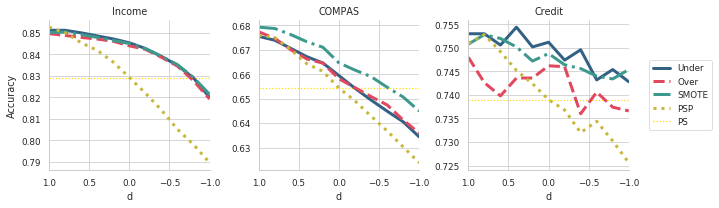

In [7]:
g = sns.FacetGrid(allMelt[allMelt.metric == 'accuracy'], col="dset", hue="strat",
                  sharey=False, hue_kws={'ls':['-', '--', '-.', ':'], 'lw':[3,3,3,3]})
g.map(plt.plot, 'd', 'value')
g.set_titles('{col_name}')
g.set_ylabels('Accuracy')

[g.axes[0][i].set_xlim([1,-1]) for i in range(3)]

psInc = allMelt[(allMelt.metric == 'accuracy')
        & (allMelt.dset == 'Income')
        & (allMelt.strat == 'PSP')
        & (allMelt.d == 0)].value.iloc[0]
      
psCOMP = allMelt[(allMelt.metric == 'accuracy')
        & (allMelt.dset == 'COMPAS')
        & (allMelt.strat == 'PSP')
        & (allMelt.d == 0)].value.iloc[0]
      
psCred = allMelt[(allMelt.metric == 'accuracy')
        & (allMelt.dset == 'Credit')
        & (allMelt.strat == 'PSP')
        & (allMelt.d == 0)].value.iloc[0]

psAccs = [psInc, psCOMP, psCred]

ax0, ax1, ax2 = g.axes[0]

ax0.axhline(psInc, ls=':', label='PS', color='gold', zorder=1)
ax1.axhline(psCOMP, ls=':', label='PS', color='gold', zorder=1)
ax2.axhline(psCred, ls=':', label='PS', color='gold', zorder=1)

plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
#plt.savefig('../Graphics/kAccs.pdf', bbox_inches='tight')
plt.show()

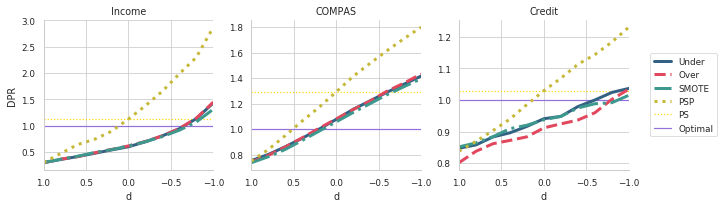

In [8]:
g = sns.FacetGrid(allMelt[allMelt.metric == 'DPR'], col="dset", hue="strat",
                  sharey=False, hue_kws={'ls':['-', '--', '-.', ':'], 'lw':[3,3,3,3]})
g.map(plt.plot, 'd', 'value')
g.set_titles('{col_name}')
g.set_ylabels('DPR')

[g.axes[0][i].set_xlim([1,-1]) for i in range(3)]

psInc = allMelt[(allMelt.metric == 'DPR')
        & (allMelt.dset == 'Income')
        & (allMelt.strat == 'PSP')
        & (allMelt.d == 0)].value.iloc[0]
      
psCOMP = allMelt[(allMelt.metric == 'DPR')
        & (allMelt.dset == 'COMPAS')
        & (allMelt.strat == 'PSP')
        & (allMelt.d == 0)].value.iloc[0]
      
psCred = allMelt[(allMelt.metric == 'DPR')
        & (allMelt.dset == 'Credit')
        & (allMelt.strat == 'PSP')
        & (allMelt.d == 0)].value.iloc[0]

psAccs = [psInc, psCOMP, psCred]

ax0, ax1, ax2 = g.axes[0]

ax0.axhline(psInc, ls=':', label='PS', color='gold', zorder=1)
ax1.axhline(psCOMP, ls=':', label='PS', color='gold', zorder=1)
ax2.axhline(psCred, ls=':', label='PS', color='gold', zorder=1)

ax0.axhline(1, ls='-', label='Optimal', color='mediumpurple', zorder=1)
ax1.axhline(1, ls='-', label='Optimal', color='mediumpurple', zorder=1)
ax2.axhline(1, ls='-', label='Optimal', color='mediumpurple', zorder=1)

plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
#plt.savefig('../Graphics/kDPR.pdf', bbox_inches='tight', title='Sampling Method')
plt.show()

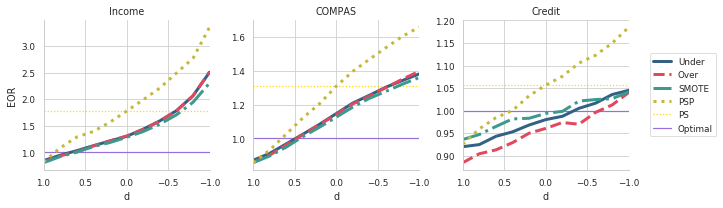

In [9]:
g = sns.FacetGrid(allMelt[allMelt.metric == 'EOR'], col="dset", hue="strat",
                  sharey=False, hue_kws={'ls':['-', '--', '-.', ':'], 'lw':[3,3,3,3]})
g.map(plt.plot, 'd', 'value')
g.set_titles('{col_name}')
g.set_ylabels('EOR')

[g.axes[0][i].set_xlim([1,-1]) for i in range(3)]

psInc = allMelt[(allMelt.metric == 'EOR')
        & (allMelt.dset == 'Income')
        & (allMelt.strat == 'PSP')
        & (allMelt.d == 0)].value.iloc[0]
      
psCOMP = allMelt[(allMelt.metric == 'EOR')
        & (allMelt.dset == 'COMPAS')
        & (allMelt.strat == 'PSP')
        & (allMelt.d == 0)].value.iloc[0]
      
psCred = allMelt[(allMelt.metric == 'EOR')
        & (allMelt.dset == 'Credit')
        & (allMelt.strat == 'PSP')
        & (allMelt.d == 0)].value.iloc[0]

psAccs = [psInc, psCOMP, psCred]

ax0, ax1, ax2 = g.axes[0]

ax0.axhline(psInc, ls=':', label='PS', color='gold', zorder=1)
ax1.axhline(psCOMP, ls=':', label='PS', color='gold', zorder=1)
ax2.axhline(psCred, ls=':', label='PS', color='gold', zorder=1)

ax0.axhline(1, ls='-', label='Optimal', color='mediumpurple', zorder=1)
ax1.axhline(1, ls='-', label='Optimal', color='mediumpurple', zorder=1)
ax2.axhline(1, ls='-', label='Optimal', color='mediumpurple', zorder=1)

plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
#plt.savefig('../Graphics/kEOR.pdf', bbox_inches='tight')
plt.show()

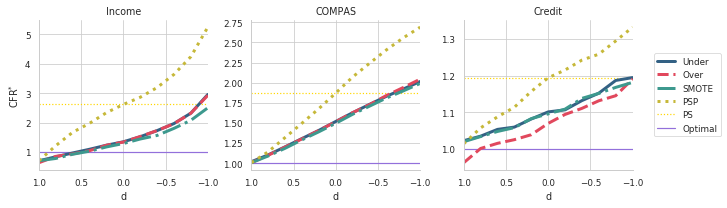

In [10]:
g = sns.FacetGrid(allMelt[allMelt.metric == 'CFR'], col="dset", hue="strat",
                  sharey=False, hue_kws={'ls':['-', '--', '-.', ':'], 'lw':[3,3,3,3]})
g.map(plt.plot, 'd', 'value')
g.set_titles('{col_name}')
g.set_ylabels('CFR$^{*}$')

[g.axes[0][i].set_xlim([1,-1]) for i in range(3)]

psInc = allMelt[(allMelt.metric == 'CFR')
        & (allMelt.dset == 'Income')
        & (allMelt.strat == 'PSP')
        & (allMelt.d == 0)].value.iloc[0]
      
psCOMP = allMelt[(allMelt.metric == 'CFR')
        & (allMelt.dset == 'COMPAS')
        & (allMelt.strat == 'PSP')
        & (allMelt.d == 0)].value.iloc[0]
      
psCred = allMelt[(allMelt.metric == 'CFR')
        & (allMelt.dset == 'Credit')
        & (allMelt.strat == 'PSP')
        & (allMelt.d == 0)].value.iloc[0]

psAccs = [psInc, psCOMP, psCred]

ax0, ax1, ax2 = g.axes[0]

ax0.axhline(psInc, ls=':', label='PS', color='gold', zorder=1)
ax1.axhline(psCOMP, ls=':', label='PS', color='gold', zorder=1)
ax2.axhline(psCred, ls=':', label='PS', color='gold', zorder=1)

ax0.axhline(1, ls='-', label='Optimal', color='mediumpurple', zorder=1)
ax1.axhline(1, ls='-', label='Optimal', color='mediumpurple', zorder=1)
ax2.axhline(1, ls='-', label='Optimal', color='mediumpurple', zorder=1)

plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
#plt.savefig('../Graphics/kCFR.pdf', bbox_inches='tight')
plt.show()

### Figure 3 plot

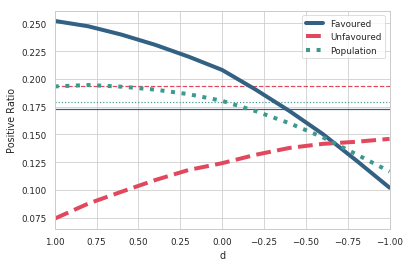

In [11]:
f = plt.figure()

plt.axhline(y=metricsPS['positive_rate'][5], color=colors[2], ls=':')
plt.axhline(y=metricsPS['unfav_positive_rate'][5], color=colors[1], ls='--')
plt.axhline(y=metricsPS['fav_positive_rate'][5], color=colors[0])

plt.plot('disparity', 'fav_positive_rate', linewidth=4,
         color=colors[0], data=metrics, label='Favoured')

plt.plot('disparity', 'unfav_positive_rate', linewidth=4,
         ls='--', color=colors[1], data=metrics, label='Unfavoured')

plt.plot('disparity', 'positive_rate', linewidth=4, 
         ls=':', color=colors[2], data=metrics, label='Population')

plt.legend()
plt.xlim(1, -1)
plt.xlabel('d')
plt.ylabel('Positive Ratio')
plt.show()
#f.savefig("../Graphics/fcPositives_" + dset + '_' + sampstrat + ".pdf", bbox_inches='tight')

### Volatility Rates (not in paper)

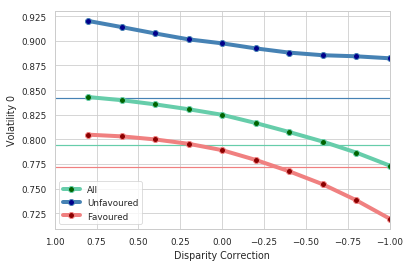

In [12]:
f = plt.figure()
plt.plot('disparity', 'vola0', marker='o', markerfacecolor='darkgreen',
         markersize=6, linewidth=4, color='mediumaquamarine', data=metrics, label='All')
plt.plot('disparity', 'unfav_vola0', marker='o', markerfacecolor='darkblue',
         markersize=6, linewidth=4, color='steelblue', data=metrics, label='Unfavoured')
plt.plot('disparity', 'fav_vola0', marker='o', markerfacecolor='darkred',
         markersize=6, linewidth=4, color='lightcoral', data=metrics, label='Favoured')

plt.axhline(y=metricsPS['vola0'][5], color = 'mediumaquamarine', zorder=1)
plt.axhline(y=metricsPS['unfav_vola0'][5], color = 'steelblue', zorder=1)
plt.axhline(y=metricsPS['fav_vola0'][5], color = 'lightcoral', zorder=1)

plt.legend()
plt.xlim(1, -1)
plt.xlabel('Disparity Correction')
plt.ylabel('Volatility 0')
plt.show()
#f.savefig("../Graphics/fcVola0_" + dset + '_' + sampstrat + ".pdf", bbox_inches='tight')

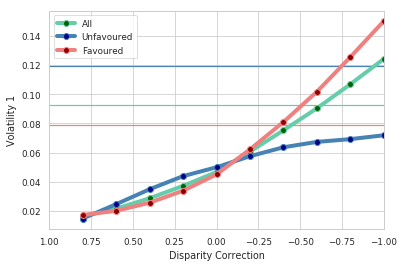

In [13]:
f = plt.figure()
plt.plot('disparity', 'vola1', marker='o', markerfacecolor='darkgreen',
         markersize=6, linewidth=4, color='mediumaquamarine', data=metrics, label='All')
plt.plot('disparity', 'unfav_vola1', marker='o', markerfacecolor='darkblue',
         markersize=6, linewidth=4, color='steelblue', data=metrics, label='Unfavoured')
plt.plot('disparity', 'fav_vola1', marker='o', markerfacecolor='darkred',
         markersize=6, linewidth=4, color='lightcoral', data=metrics, label='Favoured')

plt.axhline(y=metricsPS['vola1'][5], color = 'mediumaquamarine', zorder=1)
plt.axhline(y=metricsPS['unfav_vola1'][5], color = 'steelblue', zorder=1)
plt.axhline(y=metricsPS['fav_vola1'][5], color = 'lightcoral', zorder=1)

plt.legend()
plt.xlim(1, -1)
plt.xlabel('Disparity Correction')
plt.ylabel('Volatility 1')
plt.show()
#f.savefig("../Graphics/fcVola1_" + dset + '_' + sampstrat + ".pdf", bbox_inches='tight')

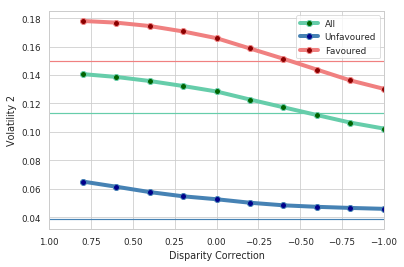

In [14]:
f = plt.figure()
plt.plot('disparity', 'vola2', marker='o', markerfacecolor='darkgreen',
         markersize=6, linewidth=4, color='mediumaquamarine', data=metrics, label='All')
plt.plot('disparity', 'unfav_vola2', marker='o', markerfacecolor='darkblue',
         markersize=6, linewidth=4, color='steelblue', data=metrics, label='Unfavoured')
plt.plot('disparity', 'fav_vola2', marker='o', markerfacecolor='darkred',
         markersize=6, linewidth=4, color='lightcoral', data=metrics, label='Favoured')

plt.axhline(y=metricsPS['vola2'][5], color = 'mediumaquamarine', zorder=1)
plt.axhline(y=metricsPS['unfav_vola2'][5], color = 'steelblue', zorder=1)
plt.axhline(y=metricsPS['fav_vola2'][5], color = 'lightcoral', zorder=1)

plt.legend()
plt.xlim(1, -1)
plt.xlabel('Disparity Correction')
plt.ylabel('Volatility 2')
plt.show()
#f.savefig("../Graphics/fcVola2_" + dset + '_' + sampstrat + ".pdf", bbox_inches='tight')

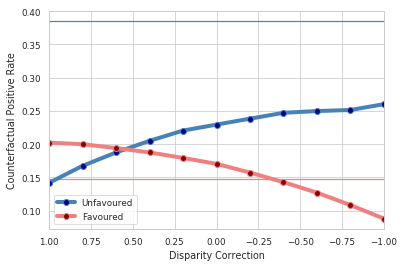

In [15]:
f = plt.figure()
plt.plot('disparity', 'unfavcf', marker='o', markerfacecolor='darkblue',
         markersize=6, linewidth=4, color='steelblue', data=metrics, label='Unfavoured')
plt.plot('disparity', 'favcf', marker='o', markerfacecolor='darkred',
         markersize=6, linewidth=4, color='lightcoral', data=metrics, label='Favoured')

plt.axhline(y=metricsPS['unfavcf'][5], color = 'steelblue', zorder=1)
plt.axhline(y=metricsPS['favcf'][5], color = 'lightcoral', zorder=1)

plt.legend()
plt.xlim(1, -1)
plt.xlabel('Disparity Correction')
plt.ylabel('Counterfactual Positive Rate')
plt.show()
#f.savefig("../Graphics/fcCPR_" + dset + '_' + sampstrat + ".pdf", bbox_inches='tight')

### Need to run the next blocks three times, once per pair: (Income, sex), (COMPAS, race) and (German, gender) as dset and pa. Otherwise, use the pregenerated Melt files

In [345]:
# dset = 'COMPAS'
# pa = 'race'

dset = 'Income'
pa = 'sex'

# dset = 'German'
# pa = 'gender'

In [346]:
dfUnder = pd.read_csv(url + 'Fairness_Coefs_' + dset + '_fairCorrectUnder.csv', header=0)
dfOver = pd.read_csv(url + 'Fairness_Coefs_' + dset + '_fairCorrectOver.csv', header=0)
dfSMOTE = pd.read_csv(url + 'Fairness_Coefs_' + dset + '_fairCorrectSMOTE.csv', header=0)
dfPSP = pd.read_csv(url + 'Fairness_Coefs_' + dset + '_fairCorrectPSP.csv', header=0)

In [347]:
dfComp = dfUnder[['disparity']].copy()
dfComp['under'] = dfUnder[pa]
dfComp['over'] = dfOver[pa]
dfComp['smote'] = dfSMOTE[pa]
dfComp['psp'] = dfPSP[pa]

dfMelt = pd.melt(dfComp, id_vars=['disparity'], value_vars=['under', 'over', 'smote', 'psp'],
                 var_name='sampling', value_name='coef')
dfMelt['dset'] = dset

In [348]:
metricsUnder = pd.read_csv(url + 'Fairness_Metrics_' + dset + '_fairCorrectUnder.csv', header=0)
metricsOver = pd.read_csv(url + 'Fairness_Metrics_' + dset + '_fairCorrectOver.csv', header=0)
metricsSMOTE = pd.read_csv(url + 'Fairness_Metrics_' + dset + '_fairCorrectSMOTE.csv', header=0)
metricsPSP = pd.read_csv(url + 'Fairness_Metrics_' + dset + '_fairCorrectPSP.csv', header=0)

In [349]:
metricsUnder['cfPar'] = metricsUnder['ucfact'] / metricsUnder['fcfact']
metricsOver['cfPar'] = metricsOver['ucfact'] / metricsOver['fcfact']
metricsSMOTE['cfPar'] = metricsSMOTE['ucfact'] / metricsSMOTE['fcfact']
metricsPSP['cfPar'] = metricsPSP['ucfact'] / metricsPSP['fcfact']

cfComp = metricsUnder[['disparity']].copy()
cfComp['under'] = metricsUnder['cfPar']
cfComp['over'] = metricsOver['cfPar']
cfComp['smote'] = metricsSMOTE['cfPar']
cfComp['psp'] = metricsPSP['cfPar']

cfMelt = pd.melt(cfComp, id_vars=['disparity'], value_vars=['under', 'over', 'smote', 'psp'],
                 var_name='sampling', value_name='rate')

dfMelt['cfRate'] = cfMelt['rate']

In [350]:
tcfComp = metricsUnder[['disparity']].copy()
tcfComp['under'] = metricsUnder['tcfact']
tcfComp['over'] = metricsOver['tcfact']
tcfComp['smote'] = metricsSMOTE['tcfact']
tcfComp['psp'] = metricsPSP['tcfact']

tcfMelt = pd.melt(tcfComp, id_vars=['disparity'], value_vars=['under', 'over', 'smote', 'psp'],
                 var_name='sampling', value_name='rate')

dfMelt['tcfRate'] = tcfMelt['rate']

In [351]:
eoComp = metricsUnder[['disparity']].copy()
eoComp['under'] = metricsUnder['eo_rate']
eoComp['over'] = metricsOver['eo_rate']
eoComp['smote'] = metricsSMOTE['eo_rate']
eoComp['psp'] = metricsPSP['eo_rate']

eoMelt = pd.melt(eoComp, id_vars=['disparity'], value_vars=['under', 'over', 'smote', 'psp'],
                 var_name='sampling', value_name='rate')

dfMelt['eoRate'] = eoMelt['rate']

In [352]:
metricsUnder['statPar'] = metricsUnder.unfav_positive_rate / metricsUnder.fav_positive_rate
metricsOver['statPar'] = metricsOver.unfav_positive_rate / metricsOver.fav_positive_rate
metricsSMOTE['statPar'] = metricsSMOTE.unfav_positive_rate / metricsSMOTE.fav_positive_rate
metricsPSP['statPar'] = metricsPSP.unfav_positive_rate / metricsPSP.fav_positive_rate

In [353]:
spComp = metricsUnder[['disparity']].copy()
spComp['under'] = metricsUnder['statPar']
spComp['over'] = metricsOver['statPar']
spComp['smote'] = metricsSMOTE['statPar']
spComp['psp'] = metricsPSP['statPar']

spMelt = pd.melt(spComp, id_vars=['disparity'], value_vars=['under', 'over', 'smote', 'psp'],
                 var_name='sampling', value_name='rate')

dfMelt['spRate'] = spMelt['rate']

In [354]:
acComp = metricsUnder[['disparity']].copy()
acComp['under'] = metricsUnder['accuracy']
acComp['over'] = metricsOver['accuracy']
acComp['smote'] = metricsSMOTE['accuracy']
acComp['psp'] = metricsPSP['accuracy']

spMelt = pd.melt(acComp, id_vars=['disparity'], value_vars=['under', 'over', 'smote', 'psp'],
                 var_name='sampling', value_name='accuracy')

dfMelt['accuracy'] = spMelt['accuracy']

In [355]:
#dfMelt.to_csv('../Datasets/Melt' + dset + '.csv', index=False)

## Can continue here using pre-generated files

In [16]:
url = 'https://raw.githubusercontent.com/vladoxNCL/fairCorrect/master/Datasets/'

mInc = pd.read_csv(url + 'MeltIncome.csv', header=0)
mCOM = pd.read_csv(url + 'MeltCOMPAS.csv', header=0)
mGer = pd.read_csv(url + 'MeltGerman.csv', header=0)

frames = [mInc, mCOM, mGer]
melts = pd.concat(frames)

### Generate the plots for figure 8 in paper

In [17]:
melts = melts.replace('German', 'Credit')

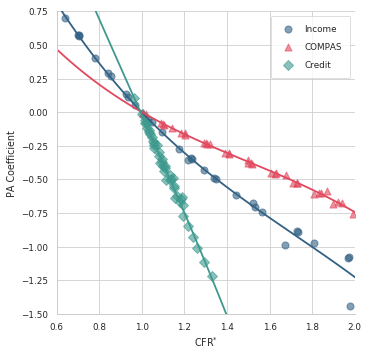

In [18]:
sns.lmplot(x="tcfRate", y="coef", hue="dset",
           data=melts[melts['tcfRate'] < 2],
           markers=["o", "^", "D"], ci=False,
           order=3, legend=False,
           scatter_kws={'alpha':0.6, 's':50})
plt.xlim((0.6,2))
plt.ylim((-1.5,0.75))
plt.xlabel('CFR$^{*}$')
plt.ylabel('PA Coefficient')
plt.legend(labelspacing=1,borderpad=1)
#plt.savefig("../Graphics/tcfCoefs.pdf", bbox_inches='tight')